In [ ]:
!wget "https://machinehack-be.s3.amazonaws.com/data_hack_mathcothon_car_price_prediction_challenge/Participant_Data_TheMathCompany_.DSHH.zip"

--2021-07-18 18:12:02--  https://machinehack-be.s3.amazonaws.com/data_hack_mathcothon_car_price_prediction_challenge/Participant_Data_TheMathCompany_.DSHH.zip
Resolving machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)... 52.219.156.15
Connecting to machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)|52.219.156.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 585753 (572K) [application/octet-stream]
Saving to: ‘Participant_Data_TheMathCompany_.DSHH.zip’

Participant_Data_Th 100%[===================>] 572.02K  1.09MB/s    in 0.5s    

2021-07-18 18:12:03 (1.09 MB/s) - ‘Participant_Data_TheMathCompany_.DSHH.zip’ saved [585753/585753]



In [2]:
!unzip "Participant_Data_TheMathCompany_.DSHH.zip"

Archive:  Participant_Data_TheMathCompany_.DSHH.zip
  inflating: train.csv               
  inflating: __MACOSX/._train.csv    
  inflating: test.csv                
  inflating: __MACOSX/._test.csv     
  inflating: submission.csv          
  inflating: __MACOSX/._submission.csv  


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip install rfpimp
!pip install catboost
from sklearn.metrics import mean_absolute_error,accuracy_score
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold,KFold,GridSearchCV,GroupKFold,train_test_split,StratifiedShuffleSplit
from rfpimp import *
from tqdm import tqdm
from catboost import *
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10668 sha256=89d00c1370d8012d74d03b16b12cc935e91206c1a696ffad01c1e87a7b40bcbb
  Stored in directory: /root/.cache/pip/wheels/ad/48/d9/21fc62fbeff405425b0d5dd8b0354576cdb62ac97f6b11d1ef
Successfully built rfpimp
     |████████████████████████████████| 69.2 MB 4.9 kB/s 


In [47]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [48]:
train.head(-2)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19230,45760891,470,645,TOYOTA,Prius,2011,Hatchback,Yes,Hybrid,1.8,307325 km,4.0,Automatic,Front,04-May,Left wheel,Silver,12
19231,45772306,5802,1055,MERCEDES-BENZ,E 350,2013,Sedan,Yes,Diesel,3.5,107800 km,6.0,Automatic,Rear,04-May,Left wheel,Grey,12
19232,45798355,8467,-,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000 km,4.0,Manual,Rear,02-Mar,Left wheel,Silver,5
19233,45778856,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.0,Tiptronic,Front,04-May,Left wheel,Red,8


In [49]:
test.head(-2)

,ID,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Price
0,44020629,-,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,2.0 Turbo,0 km,4,Manual,Front,02-Mar,Left wheel,Grey,10,NaN
1,45784798,-,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,2.4,26000 km,4,Tiptronic,Front,04-May,Left wheel,Grey,10,NaN
2,45800257,-,NISSAN,Tiida,2005,Sedan,No,Petrol,1.5,168000 km,4,Automatic,Front,04-May,Right-hand drive,Sky blue,8,NaN
3,45797981,975,VOLVO,XC90,2012,Jeep,Yes,Petrol,3.2,143000 km,6,Automatic,4x4,04-May,Left wheel,Blue,12,NaN
4,45814303,-,OPEL,Astra,1993,Hatchback,No,Petrol,1.6,200000 km,4,Manual,Front,04-May,Left wheel,Black,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8238,44012311,-,VOLKSWAGEN,CC,2009,Coupe,Yes,Petrol,2,1000 km,6,Tiptronic,Front,04-May,Left wheel,White,8,NaN
8239,45787008,645,TOYOTA,Prius,2011,Sedan,Yes,Petrol,1.8,283000 km,4,Automatic,Front,04-May,Left wheel,White,4,NaN
8240,44824410,1357,FIAT,Stilo,2004,Universal,No,Petrol,1.6,164000 km,4,Manual,Front,04-May,Left wheel,Blue,6,NaN
8241,45682346,-,BMW,528 F10,2012,Sedan,Yes,Petrol,2.8 Turbo,156000 km,4,Tiptronic,Front,04-May,Left wheel,Black,6,NaN


In [50]:
train['Price'].nlargest(10)

16983    26307500
8541       872946
1225       627220
5008       308906
9367       297930
14839      297930
7749       288521
10759      260296
5840       254024
15283      250574
Name: Price, dtype: int64

In [51]:
x=[]
for i in train['Price']:
  if i>300000:
    x.append(290000)
  else:
    x.append(i)
train['Price']=x

In [52]:
df=pd.concat([train,test])

In [53]:
df.head(5)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328.0,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621.0,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467.0,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607.0,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726.0,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [54]:
df.nunique(),df.isnull().sum()

(ID                  26886
 Price                2312
 Levy                  635
 Manufacturer           68
 Model                1981
 Prod. year             59
 Category               11
 Leather interior        2
 Fuel type               7
 Engine volume         112
 Mileage              9977
 Cylinders              16
 Gear box type           4
 Drive wheels            3
 Doors                   3
 Wheel                   2
 Color                  16
 Airbags                17
 dtype: int64, ID                     0
 Price               8245
 Levy                   0
 Manufacturer           0
 Model                  0
 Prod. year             0
 Category               0
 Leather interior       0
 Fuel type              0
 Engine volume          0
 Mileage                0
 Cylinders              0
 Gear box type          0
 Drive wheels           0
 Doors                  0
 Wheel                  0
 Color                  0
 Airbags                0
 dtype: int64)

In [55]:
df['Mileage']=df['Mileage'].str.extract('(\d+)').astype(int)

In [56]:
df['Levy']=df['Levy'].replace('-', np.nan)

In [57]:
df['Levy']=df['Levy'].fillna(method='ffill')
df['Levy']=df['Levy'].fillna(method='bfill')
df['Levy']=df['Levy'].astype(int)

In [58]:
a=[]
b=[]
for i in df['Engine volume']:
  i=i.split(' ')
  if len(i)==2:
    a.append(i[0])
    b.append(i[1])
  else:
    a.append(i[0])
    b.append('non turbo')
df['Engine volume']=a
df['Engine volume Type']=b

In [59]:
x=list(df.select_dtypes(['object']).columns)
x

['Manufacturer',
 'Model',
 'Category',
 'Leather interior',
 'Fuel type',
 'Engine volume',
 'Gear box type',
 'Drive wheels',
 'Doors',
 'Wheel',
 'Color',
 'Engine volume Type']

In [60]:
for i in x:
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  df[i] = le.fit_transform(df[i])
  df[i]=df[i]+1

In [61]:
temp = df.groupby(['Mileage']).agg({
                                      'Mileage':['count','sum','mean','median','std'],
                                      #'ID':['count','sum','mean','median','std'],
                                      'Model':['count','mean','sum','median','std'],
                                      'Prod. year':['count','mean','sum','median','std']
                                      })
temp.columns = ['_condd_'.join(x) for x in temp.columns]
df = pd.merge(df,temp,on=['Mileage'],how='left')

In [62]:
#df = pd.get_dummies(df, columns=['Manufacturer'])
xx=[]
for i in df['Mileage']:
  if i>1400000:
    xx.append(1500000)
  else:
    xx.append(i)
df['Mileage']=xx

In [63]:
del df['Doors']

In [64]:
train = df[df['Price'].isnull()==False]
test = df[df['Price'].isnull()==True]
del test['Price']
#xxx=train['Price']
#del train['Price']

In [65]:
#Statical Features Extracting from train and test rows after droping Inovicedate or Exctracting features
#Train
#train['Std'] = train.std(axis=1).round(2)
#train['quantile1'] = train.quantile(q=0.01,axis=1).round(2)
#train['quantile3'] = train.quantile(q=0.25,axis=1).round(2)
#train['quantile5'] = train.quantile(q=0.75,axis=1).round(2)                                              
#train['Mean'] = train.mean(axis=1).round(2)
#Test
#test['Std'] = test.std(axis=1).round(2)
#test['quantile1'] = test.quantile(q=0.01,axis=1).round(2)
#test['quantile3'] = test.quantile(q=0.25,axis=1).round(2)
#test['quantile5'] = test.quantile(q=0.75,axis=1).round(2)                                              
#test['Mean'] = test.mean(axis=1).round(2)

In [66]:
#train['Price']=xxx

In [67]:
train_df=train.copy()
test_df=test.copy()

In [68]:
train_df['Price'] = np.log1p(train_df['Price'])

In [69]:
X = train_df.drop(labels=['Price'], axis=1)
y = train_df['Price'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.10, random_state=42)

In [70]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((17313, 32), (17313,), (1924, 32), (1924,))

In [71]:
from sklearn.metrics import mean_squared_log_error
from math import sqrt

In [72]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.1, 
         'num_iterations': 3000,
         'num_leaves': 79,
         #'max_depth': -1,
         'min_data_in_leaf': 11,
         'bagging_fraction': 0.90,
         'bagging_freq': 1,
         'bagging_seed': 3,
         'feature_fraction': 0.90,
         'feature_fraction_seed': 2,
         'early_stopping_round': 200,
         'max_bin': 500,
         'lambda': 2.8849054495567423, 
        'alpha': 4.001054193185317787, 
        'colsample_bytree': 0.5, 
        'subsample': 0.9, 
        'max_depth': 13, 
        'random_state': 42,
        'min_child_weight': 5
         }

lgbm = lgb.train(params=param, verbose_eval=100, train_set=train_data, valid_sets=[test_data])

y_pred_lgbm = lgbm.predict(X_cv)
print('MSLE:', (mean_squared_log_error(np.expm1(y_cv), np.expm1(y_pred_lgbm))))

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 0.788677
[200]	valid_0's rmse: 0.763914
[300]	valid_0's rmse: 0.756957
[400]	valid_0's rmse: 0.75395
[500]	valid_0's rmse: 0.755188
[600]	valid_0's rmse: 0.755732
Early stopping, best iteration is:
[405]	valid_0's rmse: 0.753535
MSLE: 0.5678156165382487


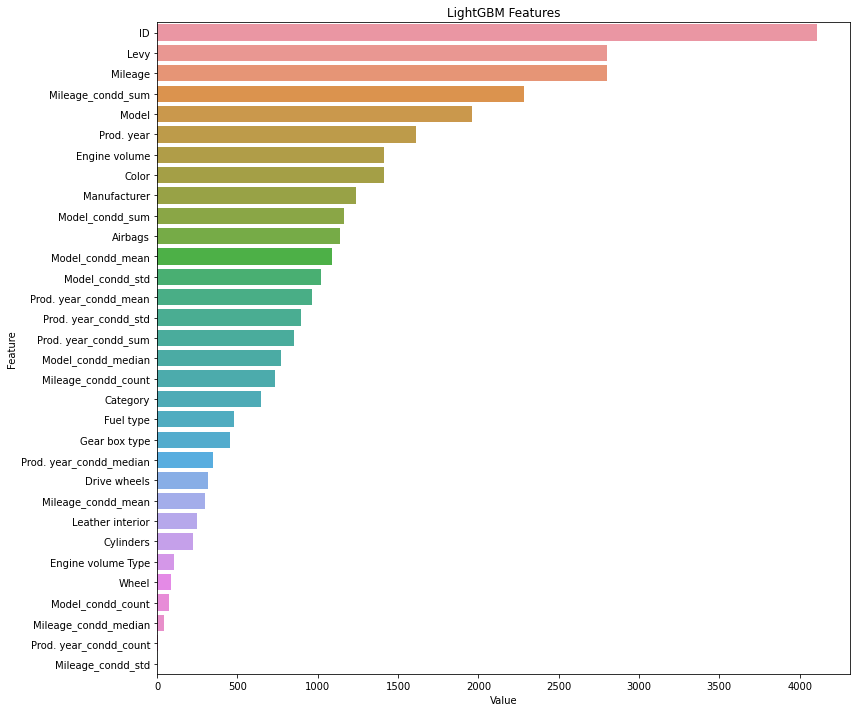

In [73]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(), X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [74]:
Xtest = test_df

In [75]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm = LGBMRegressor(n_estimators=10000,**param,verbose= -1)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200)

    y_pred_lgbm = lgbm.predict(X_test)
    print("RMSLE LGBM: ", sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_lgbm))))

    errlgb.append(sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_lgbm))))
    p = lgbm.predict(Xtest)
    y_pred_totlgb.append(p)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.7610620866188231


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.8721762178840969


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.8271358458196282


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.8706722660289311


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.9147619404142843


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.8245159895906176


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.8222634164110748


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.8840190101379818


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.8565634737729116


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.8640888174488549


In [76]:
np.mean(errlgb,0)

0.8497259064127205

In [94]:
lgbm_final = np.expm1(np.mean(y_pred_totlgb,0))
lgbm_final

array([15494.21521  , 11193.8699   ,  7173.718425 , ...,   281.177037 ,
       36617.31448  ,   533.2532193])

In [97]:
submission = pd.DataFrame({
        "Price": lgbm_final #*0.97 #0.95,1.02,1.05
    })
submission.to_csv('./realdem.csv', index=False)
print(submission)

             Price
0     15494.215210
1     11193.869900
2      7173.718425
3     17170.851340
4      1364.402810
...            ...
8240   4225.053782
8241  24020.936650
8242    281.177037
8243  36617.314480
8244    533.253219

[8245 rows x 1 columns]
